# Teste Técnico = Risco de diabetes

In [243]:
#%pip install numpy
#%pip install pandas
#%pip install seaborn
#%pip install scikit-learn
#%pip install dfply
#%pip install streamlit
#%pip install xgboost
#%pip install shap
#%pip install statsmodels
#%pip install streamlit-shap

# Bibliotecas

In [244]:
import pandas as pd
import numpy as np
from dfply import *
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm # ver o resumo do modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import spearmanr

pd.set_option('display.max_columns', None)
%matplotlib inline

import xgboost  as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve , auc, mean_squared_error, mean_absolute_error,recall_score,precision_score
import shap 
import joblib ## Salvar modelo como pickle
from joblib import dump


# 1. Carregar dataset

In [245]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df["id"] = df.index # criando um id de registro
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,id
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,2
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,3
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,4


In [246]:
df.shape

(253680, 23)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

# 2. Análise Exploratória (EDA) - Análise de correlação

## Distribuição Alvo

In [248]:
df.Diabetes_012.value_counts()
df['situacao_entrevistado']=np.where(df["Diabetes_012"] == 0, "sem_diabetes", "pre_com_diabetes")
df=df.drop(columns=["Diabetes_012"])
df['situacao_entrevistado'].value_counts(normalize=True)

situacao_entrevistado
sem_diabetes        0.842412
pre_com_diabetes    0.157588
Name: proportion, dtype: float64

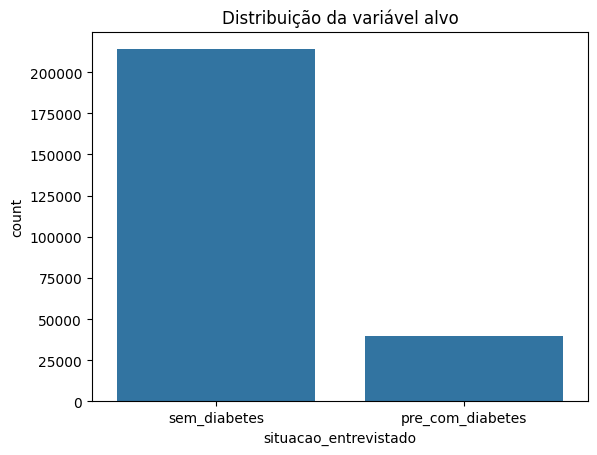

In [249]:
# Visualização gráfica da variável alvo
sns.countplot(x="situacao_entrevistado", data=df)
plt.title("Distribuição da variável alvo")
plt.show()

## Variáveis numéricas

In [250]:
df[["BMI","MentHlth","PhysHlth"]].describe()

,BMI,MentHlth,PhysHlth
count,253680.000000,253680.000000,253680.000000
mean,28.382364,3.184772,4.242081
std,6.608694,7.412847,8.717951
min,12.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000
75%,31.000000,2.000000,3.000000
max,98.000000,30.000000,30.000000


## Variáveis Categóricas

In [251]:
# Selecionando apenas colunas categóricas
colunas_categoricas=df.drop(columns=["id","BMI","MentHlth","PhysHlth","situacao_entrevistado"]).columns.to_list()


# Criando tabelas de contingência para cada variável categórica
for col in colunas_categoricas:
    print(f"\nTabela de Frequência: {col}")
    tabela=df[col].value_counts(dropna=False)
    print(tabela)


Tabela de Frequência: HighBP
HighBP
0.0    144851
1.0    108829
Name: count, dtype: int64

Tabela de Frequência: HighChol
HighChol
0.0    146089
1.0    107591
Name: count, dtype: int64

Tabela de Frequência: CholCheck
CholCheck
1.0    244210
0.0      9470
Name: count, dtype: int64

Tabela de Frequência: Smoker
Smoker
0.0    141257
1.0    112423
Name: count, dtype: int64

Tabela de Frequência: Stroke
Stroke
0.0    243388
1.0     10292
Name: count, dtype: int64

Tabela de Frequência: HeartDiseaseorAttack
HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

Tabela de Frequência: PhysActivity
PhysActivity
1.0    191920
0.0     61760
Name: count, dtype: int64

Tabela de Frequência: Fruits
Fruits
1.0    160898
0.0     92782
Name: count, dtype: int64

Tabela de Frequência: Veggies
Veggies
1.0    205841
0.0     47839
Name: count, dtype: int64

Tabela de Frequência: HvyAlcoholConsump
HvyAlcoholConsump
0.0    239424
1.0     14256
Name: count, dtype: int64

Tabela de Frequ

In [252]:
# Tabela cruzada com totais
ct = pd.crosstab(df["Smoker"], df["situacao_entrevistado"], margins=True, margins_name="Total")

#Percentual por linha (sem incluir a linha Total)
ct_percent = pd.crosstab(df["Smoker"], df["situacao_entrevistado"],margins=True,margins_name="Total", normalize="index") * 100
ct_percent = ct_percent.round(2)

# Combinar totais e percentuais
ct_combined = ct.copy()

for col in df["situacao_entrevistado"].unique():
    ct_combined[f"{col} %"] = ct_percent[col]

print(ct_combined)

situacao_entrevistado  pre_com_diabetes  sem_diabetes   Total  sem_diabetes %  \
Smoker                                                                          
0.0                               19378        121879  141257           86.28   
1.0                               20599         91824  112423           81.68   
Total                             39977        213703  253680           84.24   

situacao_entrevistado  pre_com_diabetes %  
Smoker                                     
0.0                                 13.72  
1.0                                 18.32  
Total                               15.76  


## Analise de Correlação

In [253]:
# Variável alvo em numérica
df['situacao_entrevistado'] = df['situacao_entrevistado'].map({'pre_com_diabetes': 1, 'sem_diabetes': 0})
df['situacao_entrevistado'] = df['situacao_entrevistado'].astype(int)

In [254]:
# variáveis numéricas + target
df_corr = df.drop(columns=["id"]).copy()

# Lista de resultados
resultados = []

for col in df_corr.columns.drop("situacao_entrevistado"):
    x = df_corr[col]
    y = df_corr["situacao_entrevistado"]
    
    # Remove NaNs e alinha os dados
    dados = df_corr[[col, "situacao_entrevistado"]].dropna()
    x_clean = dados[col]
    y_clean = dados["situacao_entrevistado"]
    
    # Spearman
    r_spearman, p_spearman = spearmanr(x_clean, y_clean)
    
    resultados.append({
        "variável": col,
        "corr": r_spearman,
        "p": p_spearman
    })

# DataFrame com os resultados
corr_resultados = pd.DataFrame(resultados)

# Adiciona se é estatisticamente significativo ao nível de 5% - Ou seja, rejeita-se a hip nula de que não há correlação
corr_resultados["sig_5%"] = corr_resultados["p"] < 0.05

# Ordenar pela correlação em valor absoluto
corr_resultados = corr_resultados.reindex(
    corr_resultados["corr"].abs().sort_values(ascending=False).index
)
print(corr_resultados.round(4))

                variável    corr    p  sig_5%
13               GenHlth  0.2957  0.0    True
0                 HighBP  0.2703  0.0    True
3                    BMI  0.2351  0.0    True
16              DiffWalk  0.2222  0.0    True
1               HighChol  0.2103  0.0    True
18                   Age  0.1859  0.0    True
6   HeartDiseaseorAttack  0.1769  0.0    True
20                Income -0.1724  0.0    True
15              PhysHlth  0.1609  0.0    True
19             Education -0.1267  0.0    True
7           PhysActivity -0.1214  0.0    True
5                 Stroke  0.1048  0.0    True
2              CholCheck  0.0679  0.0    True
4                 Smoker  0.0628  0.0    True
9                Veggies -0.0592  0.0    True
10     HvyAlcoholConsump -0.0567  0.0    True
14              MentHlth  0.0453  0.0    True
8                 Fruits -0.0421  0.0    True
12           NoDocbcCost  0.0380  0.0    True
17                   Sex  0.0296  0.0    True
11         AnyHealthcare  0.0141  

<function matplotlib.pyplot.show(close=None, block=None)>

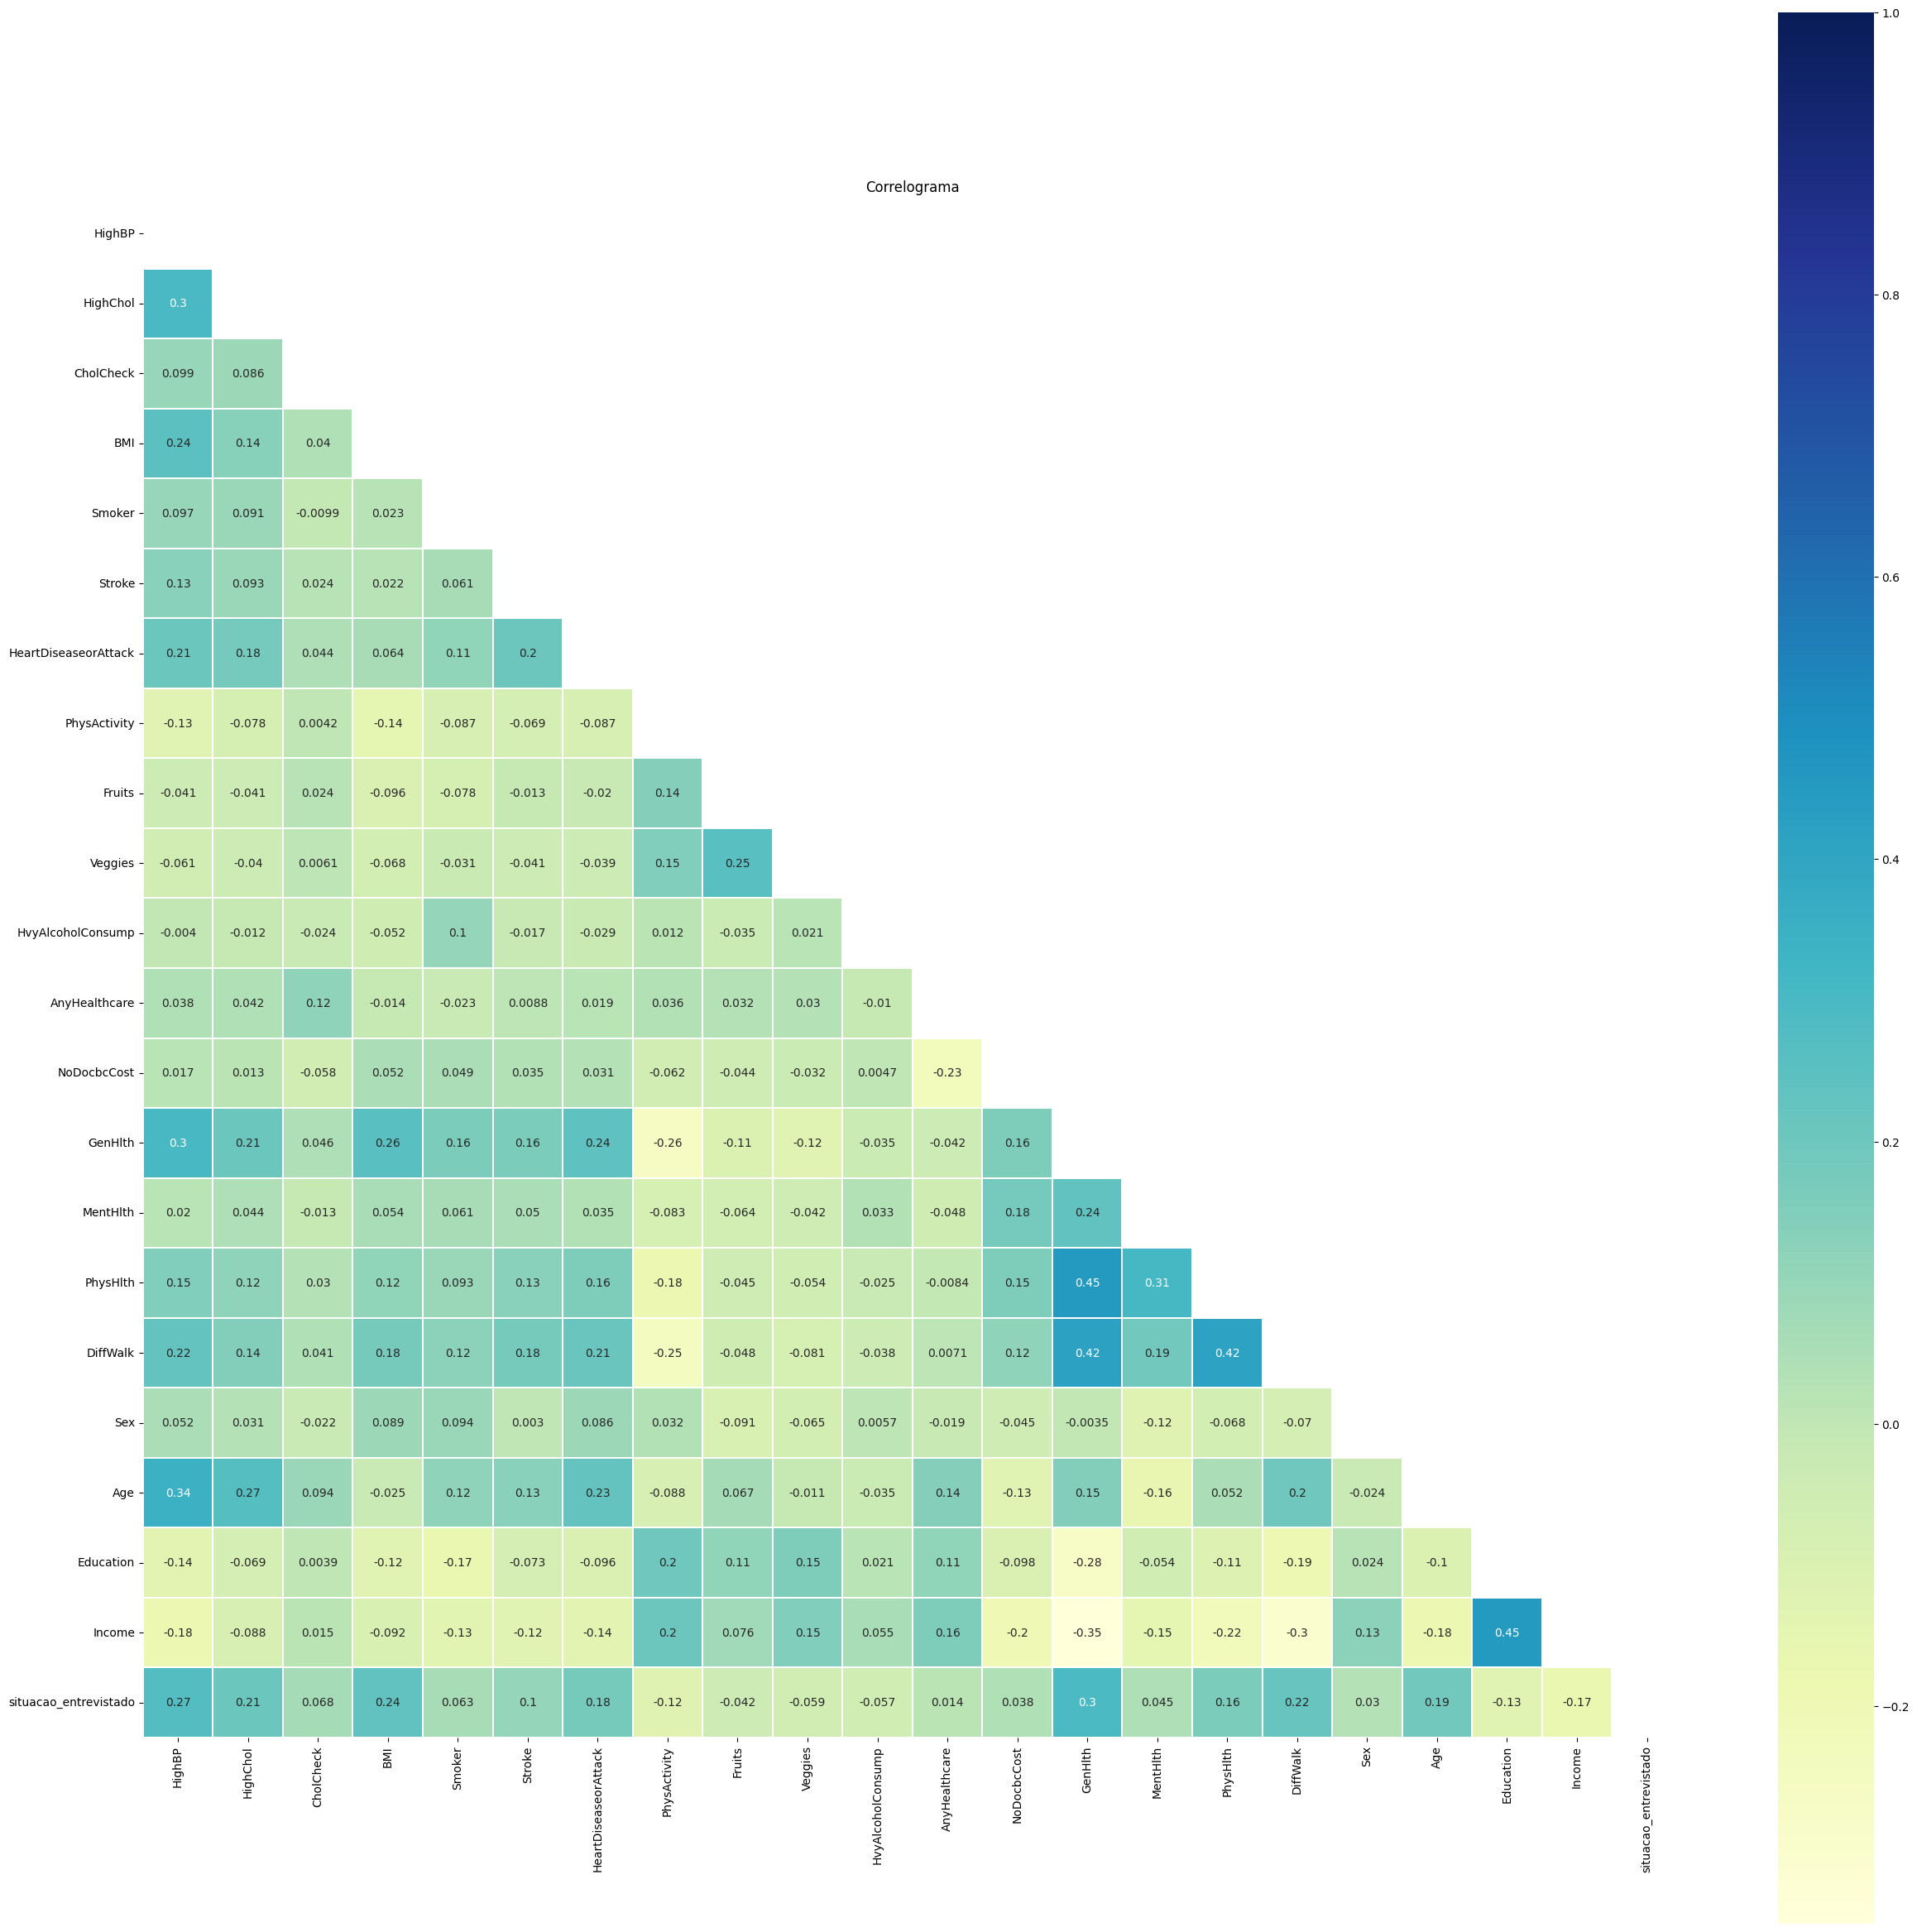

In [255]:
# Correlação entre covariáveis
# Pearson
corr=df_corr.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
w=h=30
plt.figure(figsize=(h,w))
sns.heatmap(corr,mask=mask,vmax=1.0,linewidths=0.01,
           square=True, annot=True,cmap='YlGnBu', linecolor='white')
plt.title('Correlograma')
plt.show

# 3. Preparação dos dados - Amostragem e Pré-processamento dos dados

In [256]:
df_select=df.copy()

In [257]:
# Porcentagem de valores faltantes
(df_select.isnull().sum()).sort_values(ascending=False)

HighBP                   0
HighChol                 0
CholCheck                0
BMI                      0
Smoker                   0
Stroke                   0
HeartDiseaseorAttack     0
PhysActivity             0
Fruits                   0
Veggies                  0
HvyAlcoholConsump        0
AnyHealthcare            0
NoDocbcCost              0
GenHlth                  0
MentHlth                 0
PhysHlth                 0
DiffWalk                 0
Sex                      0
Age                      0
Education                0
Income                   0
id                       0
situacao_entrevistado    0
dtype: int64

In [258]:
# 4. Preparação dos dados

# Amostragem

#Variável de interesse
alvo = df_select >> select(X.situacao_entrevistado)

# Remover a variável alvo do conjunto de dados
df_select.drop(['situacao_entrevistado'],axis=1, inplace=True)


# Separação em teste e treino

## Definindo treino e teste
X_train, X_test, y_train, y_test=train_test_split(df_select,alvo, test_size=0.3, random_state=2025)

print(X_train.shape) #qtd treino
print(X_test.shape) #qtd teste

(177576, 22)
(76104, 22)


In [259]:
# Frequência da variável alvo no treino e teste
print(y_train.value_counts(normalize=True)) #qtd treino
print(y_test.value_counts(normalize=True)) #qtd teste

situacao_entrevistado
0                        0.842079
1                        0.157921
Name: proportion, dtype: float64
situacao_entrevistado
0                        0.843188
1                        0.156812
Name: proportion, dtype: float64


In [260]:
ids_train = X_train["id"]  
X_train = X_train.drop(columns=["id"])
ids_test = X_test["id"]  
X_test = X_test.drop(columns=["id"])

# 4. Modelagem

In [261]:
# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced",max_iter=1000)
log_reg.fit(X_train, y_train)
previsao_logistico = log_reg.predict(X_test)
joblib.dump(log_reg, "log_reg.pkl")

# Random Forest
rf = RandomForestClassifier(class_weight ='balanced',n_estimators=20, random_state=42)
rf.fit(X_train, y_train)
previsao_rf = rf.predict(X_test)
dump(rf, "rf.joblib", compress=3)
#joblib.dump(rf, "rf.pkl")


# XGBoost
xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss",n_estimators=200, random_state=42)
xgb.fit(X_train, y_train)
previsao_xgb = xgb.predict(X_test)
joblib.dump(xgb, "xgb.pkl")

c:\Users\fernando.monteiro\OneDrive - BHS\Área de Trabalho\diabetes_012_health_indicators_BRFSS2015.csv\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\fernando.monteiro\OneDrive - BHS\Área de Trabalho\diabetes_012_health_indicators_BRFSS2015.csv\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['xgb.pkl']

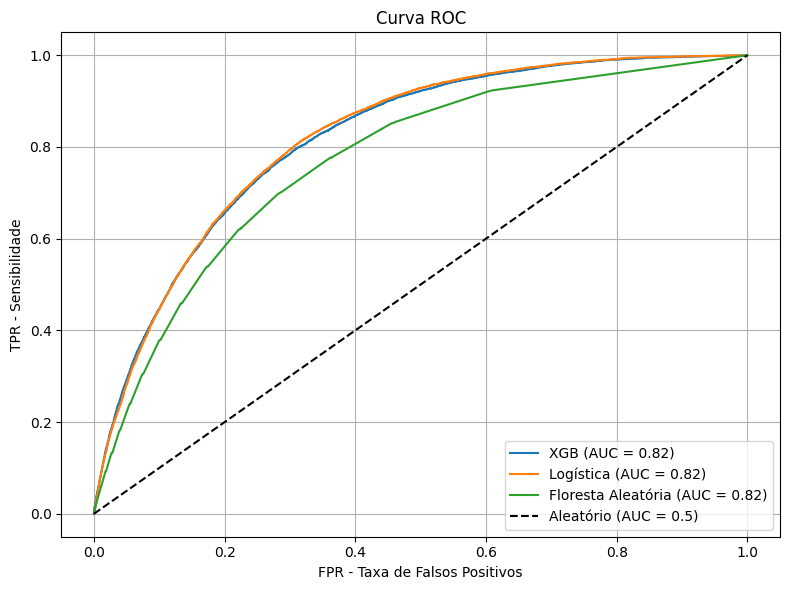

In [262]:
## Curva ROC

# Probabilidades da classe positiva (geralmente a segunda coluna [:,1])
prob_xgb = xgb.predict_proba(X_test)[:, 1]
prob_log = log_reg.predict_proba(X_test)[:, 1]
prob_fa = rf.predict_proba(X_test)[:, 1]

# Calcular pontos da curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, prob_xgb)
fpr_log, tpr_log, _ = roc_curve(y_test, prob_log)
fpr_fa, tpr_fa, _ = roc_curve(y_test, prob_fa)

# Calcular AUC
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_log = auc(fpr_log, tpr_log)
auc_fa = auc(fpr_fa, tpr_fa)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')
plt.plot(fpr_log, tpr_log, label=f'Logística (AUC = {auc_log:.2f})')
plt.plot(fpr_fa, tpr_fa, label=f'Floresta Aleatória (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
plt.xlabel('FPR - Taxa de Falsos Positivos')
plt.ylabel('TPR - Sensibilidade')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [263]:
# Matriz de confusão
# Rótulos das classes
labels = [0, 1]
cm_logistico = confusion_matrix(y_test, previsao_logistico,labels=labels)

# Matriz de confusão bonitinha
# Minimizar o Erro do tipo I: Classificar um cliente bom como ruim é maximizar a especificidade
# Minimizar o Erro do tipo II: Classificar um cliente ruim como bom é maximizar o recall/Sensibilidade

# Logistica
cm_logistico_df = pd.DataFrame(cm_logistico, index=[f'Real {label}' for label in labels],
                        columns=[f'Previsto {label}' for label in labels])
cm_logistico_df['Total Linha'] = cm_logistico_df.sum(axis=1)
cm_logistico_df.loc['Total Coluna'] = cm_logistico_df.sum()

# Cálculo de métricas
tn_log, fp_log, fn_log, tp_log = cm_logistico.ravel()
especificidade_log = tn_log / (tn_log + fp_log)
vpn_log = tn_log / (tn_log + fn_log)
recall_log = recall_score(y_test, previsao_logistico)
media_rec_spec_log = np.sqrt(recall_log * especificidade_log)



print("Matriz de Confusão Logística:\n", cm_logistico_df)


Matriz de Confusão Logística:
               Previsto 0  Previsto 1  Total Linha
Real 0             46358       17812        64170
Real 1              2770        9164        11934
Total Coluna       49128       26976        76104


In [264]:
import builtins
## indicadores de performance

# Acurácia
print('Acurácia_Logística:', builtins.round(accuracy_score(y_test, previsao_logistico),4))

# AUC
print('AUC_Logística:', builtins.round(roc_auc_score(y_test, previsao_logistico),4))

# F1-Score
print('F1_Logística:', builtins.round(f1_score(y_test, previsao_logistico),4))

# Sensibilidade (Recall)
print('Recall_Logística:', builtins.round(recall_log,4)) # Sensibilidade

# Precisão
print('Precisão_Logística:', builtins.round(precision_score(y_test, previsao_logistico), 4))

# Especificidade
print('Especificidade_Logística:', builtins.round(especificidade_log, 4))

# VPN 
print('VPN_Logística:', builtins.round(vpn_log, 4))

# Média Geométrica entre o Recall e Especificidade
print('Média Recall+Especificidade_Logística:', builtins.round(media_rec_spec_log, 4))

Acurácia_Logística: 0.7296
AUC_Logística: 0.7452
F1_Logística: 0.471
Recall_Logística: 0.7679
Precisão_Logística: 0.3397
Especificidade_Logística: 0.7224
VPN_Logística: 0.9436
Média Recall+Especificidade_Logística: 0.7448


In [265]:
X_const = sm.add_constant(X_train)
modelo_logit = sm.Logit(y_train, X_const)
resultado = modelo_logit.fit()
print(resultado.summary())

Optimization terminated successfully.
         Current function value: 0.346712
         Iterations 8
                             Logit Regression Results                            
Dep. Variable:     situacao_entrevistado   No. Observations:               177576
Model:                             Logit   Df Residuals:                   177554
Method:                              MLE   Df Model:                           21
Date:                   Thu, 28 Aug 2025   Pseudo R-squ.:                  0.2052
Time:                           21:08:28   Log-Likelihood:                -61568.
converged:                          True   LL-Null:                       -77460.
Covariance Type:               nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -7.4416      0.103    -72.248      0.000

In [266]:
# Qual o efeito das caracteristicas sobre o risco de diabetes?
coef_df = pd.DataFrame({
    'Variável': X_train.columns,
    'Coeficiente': log_reg.coef_[0],
    'Odds Ratio': np.exp(log_reg.coef_[0])
}).sort_values(by='Coeficiente', ascending=False)
print(coef_df)

                Variável  Coeficiente  Odds Ratio
2              CholCheck     1.210586    3.355450
0                 HighBP     0.693122    1.999950
1               HighChol     0.590880    1.805577
13               GenHlth     0.544501    1.723748
17                   Sex     0.261557    1.298951
6   HeartDiseaseorAttack     0.202370    1.224301
18                   Age     0.149568    1.161332
5                 Stroke     0.146678    1.157981
12           NoDocbcCost     0.115658    1.122612
16              DiffWalk     0.094663    1.099289
3                    BMI     0.072402    1.075088
11         AnyHealthcare     0.049082    1.050307
14              MentHlth    -0.002273    0.997729
4                 Smoker    -0.003163    0.996842
15              PhysHlth    -0.006503    0.993518
7           PhysActivity    -0.042284    0.958598
9                Veggies    -0.043407    0.957522
8                 Fruits    -0.044098    0.956861
19             Education    -0.048503    0.952655


# 5. Análise SHAP

In [267]:
# Shap
shap.initjs()
# Objeto explainer - XGBoost:TreeExplainer, Floresta Aleatoria:Explainer, Regressão Logística: LinearExplainer
explainer = shap.LinearExplainer(log_reg,X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train)

# Calcular os valores SHAP no conjunto de treino
shap_values = explainer(X_train)

c:\Users\fernando.monteiro\OneDrive - BHS\Área de Trabalho\diabetes_012_health_indicators_BRFSS2015.csv\.venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


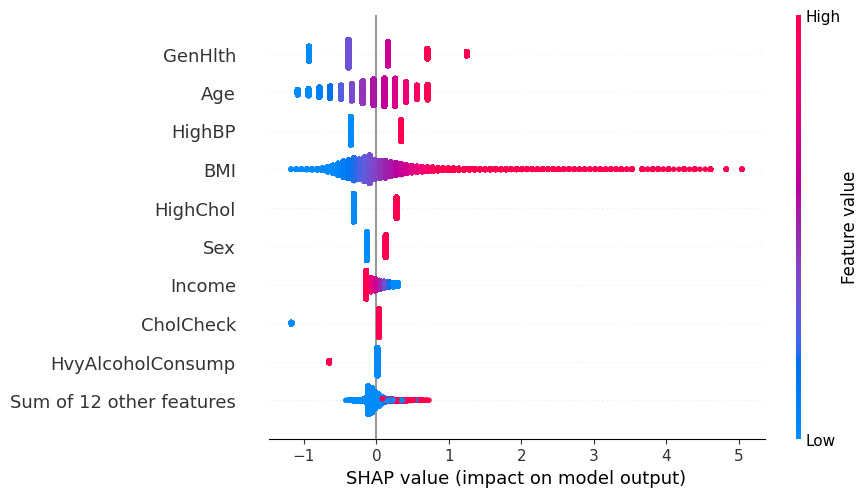

In [268]:
shap.plots.beeswarm(shap_values)

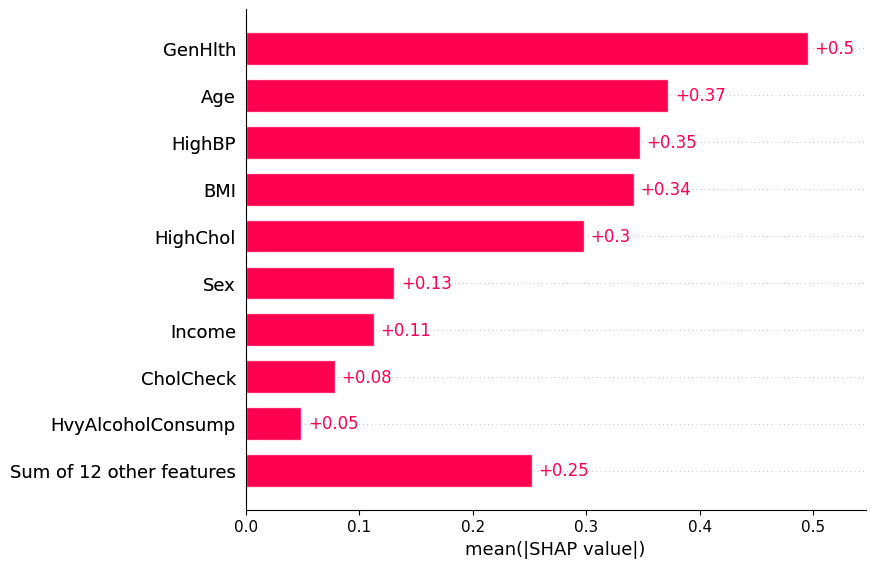

In [269]:
# Resumo Geral
shap.plots.bar(shap_values)

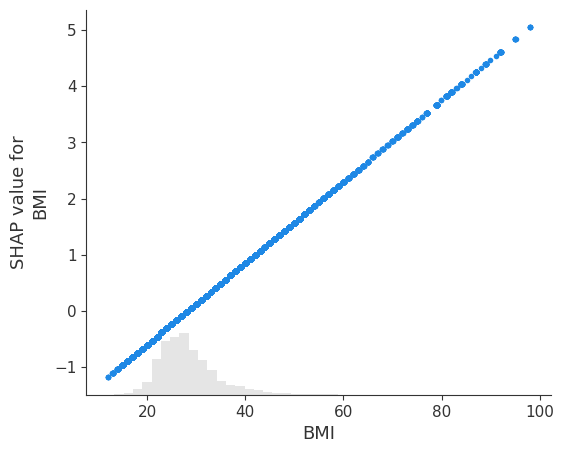

In [270]:
# Resumo Geral
feature_name = "BMI"
feature_index = X_train.columns.get_loc(feature_name)
shap.plots.scatter(shap_values[:, feature_index])

# 6. Análise de Risco de Diabetes

In [271]:
#### Pontuação Teste
# pontuar
prob_test = log_reg.predict_proba(X_test)[:, 1]
X_test_comp = X_test.copy()
X_test_comp["id_entrevistado"] = ids_test.values
X_test_comp["prob_diabetes(%)"] = np.round(prob_test,4)*100

# Categorização 'Risco'
condicoes = [
    (X_test_comp["prob_diabetes(%)"] < 50),
    (X_test_comp["prob_diabetes(%)"] >= 50) & (X_test_comp["prob_diabetes(%)"] <= 70),
    (X_test_comp["prob_diabetes(%)"] > 70),
]

classe = ["Baixo Risco", "Médio Risco", "Alto Risco"]

X_test_comp["Grupo_de_Risco"] = np.select(condicoes, classe, default="Não Classificado")


relatorio=X_test_comp[["id_entrevistado"] + list(X_test.columns) + ["prob_diabetes(%)","Grupo_de_Risco"]]
relatorio.to_csv("relatorio.csv", index=False)

In [272]:
relatorio.Grupo_de_Risco.value_counts(normalize=True)

Grupo_de_Risco
Baixo Risco    0.645511
Médio Risco    0.177257
Alto Risco     0.177231
Name: proportion, dtype: float64